In [ ]:
# List of modules that are not installed in the course
!pip install OpenPermID
!pip install geocoder
!pip install matplotlib
!pip install xlrd==1.2.0
!pip install xlsxwriter
!pip install sklearn
!pip install ipywidgets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Downloading all bonds ever owned in CSPP

In [2]:
from functions import downloadECBBonds

In [3]:
holdingsECB = downloadECBBonds.download_ECB_Bonds()

# ECB green bonds that are listed on Euronext stock exchange 

TODO: make 1 function in .py file

In [4]:
#reading data of green bonds listed on Euronext 
euronext_greenbonds = pd.read_excel("data/Euronext-Green-Bond-List.xlsx", header=0)
#Getting the ISIN of the Euronext green bonds 
euronext_greenbond_isin = euronext_greenbonds["ISIN"]
#Comparing the ISINs of the ECB and Euronext green bonds and returning matches 
ecbgreenbonds = holdingsECB[(holdingsECB["ISIN"].isin(euronext_greenbond_isin))]

TODO: calculate percentage green before and after 2020

# Read all the Eikon data

In [5]:
from functions import readEikonData
eikon_data_complete = readEikonData.get_eikon_data_complete()
eligible_complete = readEikonData.get_data_eligible_complete() # read all data from eligible universe

Compare how many bonds from the eligible universe the ECB bought.

In [6]:
overlap = eikon_data_complete[(eikon_data_complete["ISIN"].isin(eligible_complete["ISIN"]))]
print("the percentage of bonds bought by ECB in eligible universe that we have info on:    ", 
      overlap.shape[0]/eligible_complete.shape[0])

the percentage of bonds bought by ECB in eligible universe that we have info on:     0.16143170197224252


Read the dates

In [7]:
years_issuer_bought = readEikonData.get_dates_data_frame()

# Sector Analysis

## Get all sector data from PermID

In [8]:
from functions import permidSectors
sector_mappings = permidSectors.get_sector_mappings(holdingsECB)
sector_mappings.dropna(inplace = True)

## Represent industries and sectors

Create a pie chart to represent the number of times an industry, sector or supersector is present in the data (multiple bonds for the same company are counted separately)

In [9]:
from functions import pieCharts

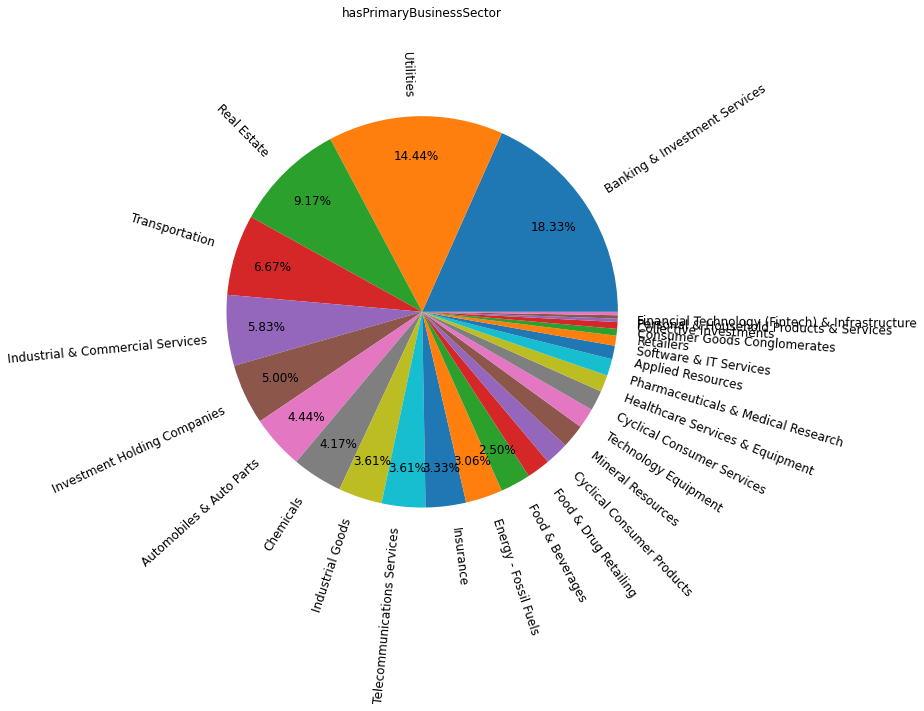

In [10]:
pieCharts.make_pie_chart('hasPrimaryBusinessSector', sector_mappings)

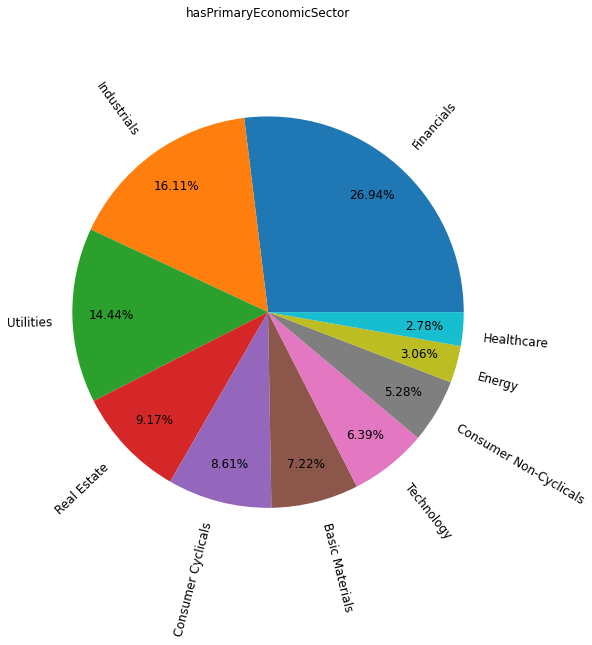

In [11]:
pieCharts.make_pie_chart('hasPrimaryEconomicSector', sector_mappings)

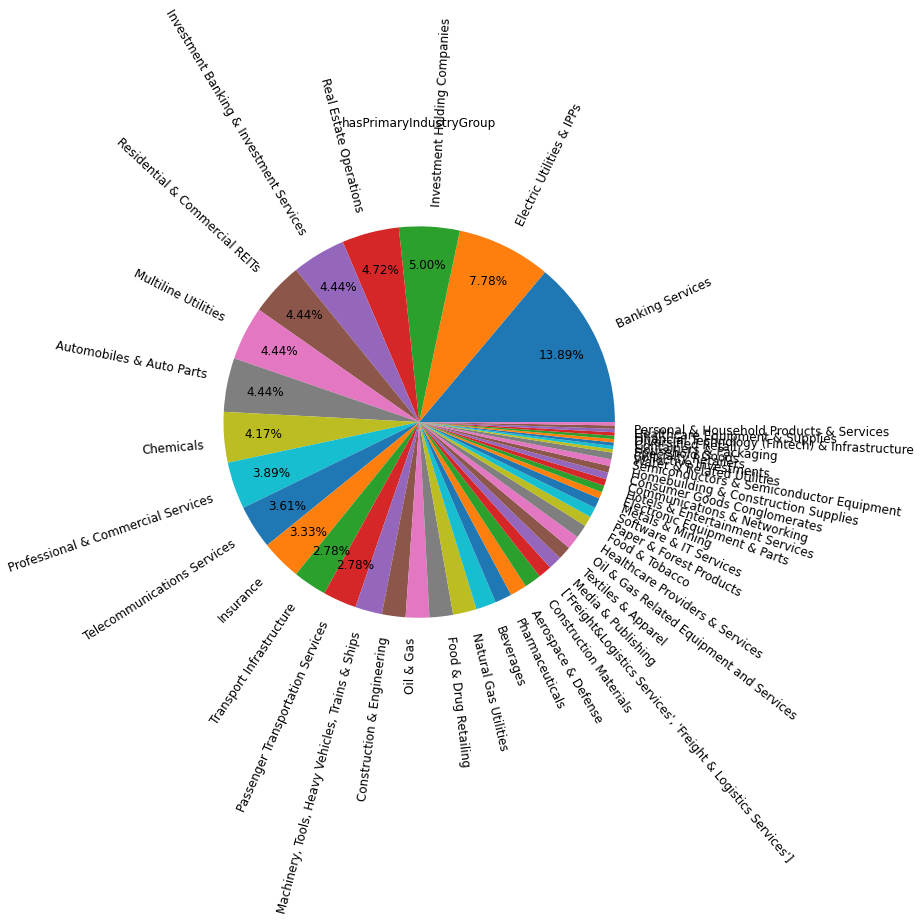

In [12]:
pieCharts.make_pie_chart('hasPrimaryIndustryGroup', sector_mappings)

## Which industries and sectors are green?

Map the dictionary with greenness of all PermID sectors with the ones in which ECB invested



In [13]:
from functions import sectors
sector_green_dict = sectors.get_sector_green_dict()

In [14]:
primary_business_sector = pieCharts.get_all_sectors("hasPrimaryBusinessSector", sector_mappings)
primary_business_sector = sectors.map_green_dict_to_data_frame(primary_business_sector)

- Total Count for each sector overall and compare these sectors (we view as “bad”, like cement, oil&gas or with kaggle dataset(emission))
- Similar approach but per year → do we see a change in habit, total counts → differences in the sectors 
- For the sectors: make spaghetti plot with for each sector the percentage invested in every year (in app: select which sectors you want)
    - Include in app (can view all, and have “buttons” to choose what to show) 
    - Make percentages instead of absolute counts
    - Remove before 2017

In [15]:
sector_mappings["Greenness"] = sector_mappings["hasPrimaryBusinessSector"].dropna().apply(lambda x: sector_green_dict[x])

C:\Users\brian\Documents\ECB-Bond-Purchases\functions\sectors.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors_spaghetti_data_frame[sector][i] = year_x_count_sector[str(i+2017)]


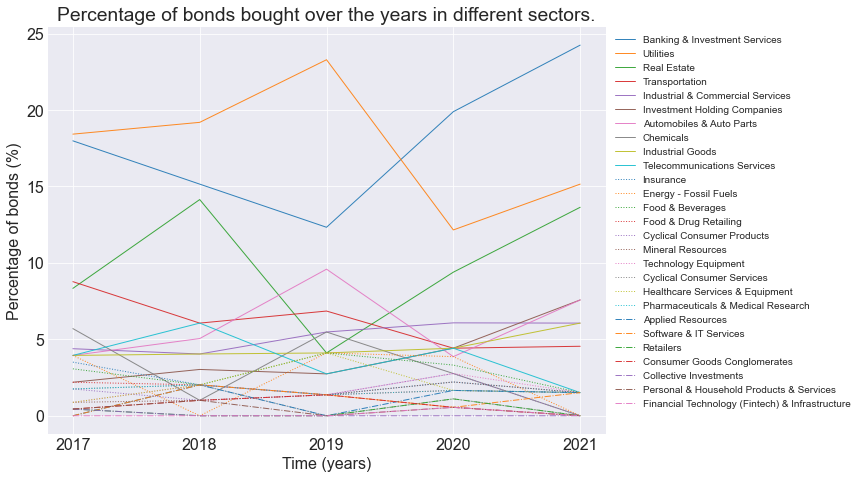

In [16]:
# Draw a spaghetti plot for all the sectors
sectors.draw_spaghetti_plot_sectors(primary_business_sector, sector_mappings, years_issuer_bought)

C:\Users\brian\Documents\ECB-Bond-Purchases\functions\sectors.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors_spaghetti_data_frame[sector][i] = year_x_count_sector[str(i+2017)]


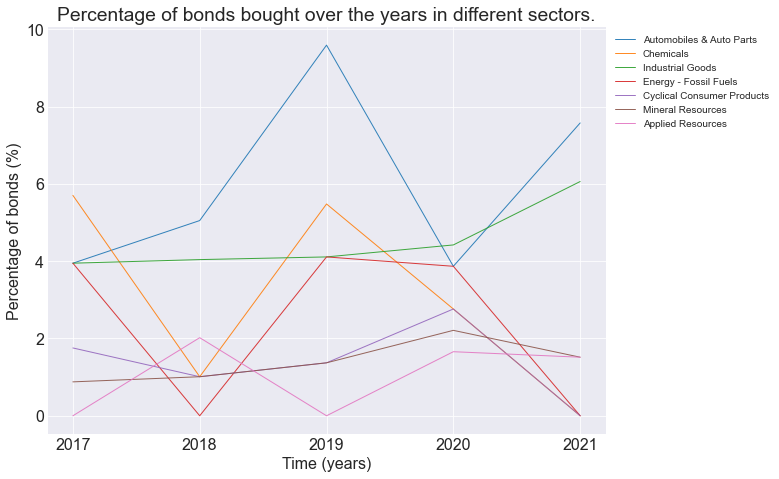

In [17]:
# Draw a spaghetti plot for the grey sectors
grey_sectors = primary_business_sector[primary_business_sector["green"]==-1].index
sectors.draw_spaghetti_plot_sectors(primary_business_sector, sector_mappings, years_issuer_bought, grey_sectors)

C:\Users\brian\Documents\ECB-Bond-Purchases\functions\sectors.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors_spaghetti_data_frame[sector][i] = year_x_count_sector[str(i+2017)]


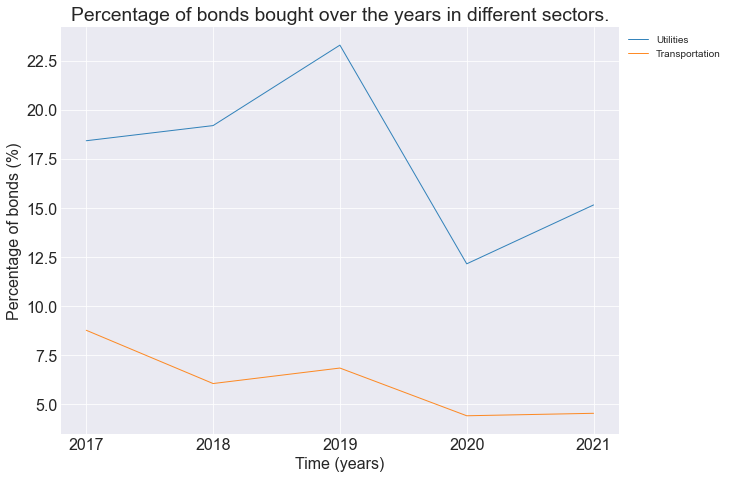

In [18]:
# Draw a spaghetti plot for the green sectors
green_sectors = primary_business_sector[primary_business_sector["green"]==1].index
sectors.draw_spaghetti_plot_sectors(primary_business_sector, sector_mappings, years_issuer_bought, green_sectors)

C:\Users\brian\Documents\ECB-Bond-Purchases\functions\sectors.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors_spaghetti_data_frame[sector][i] = year_x_count_sector[str(i+2017)]


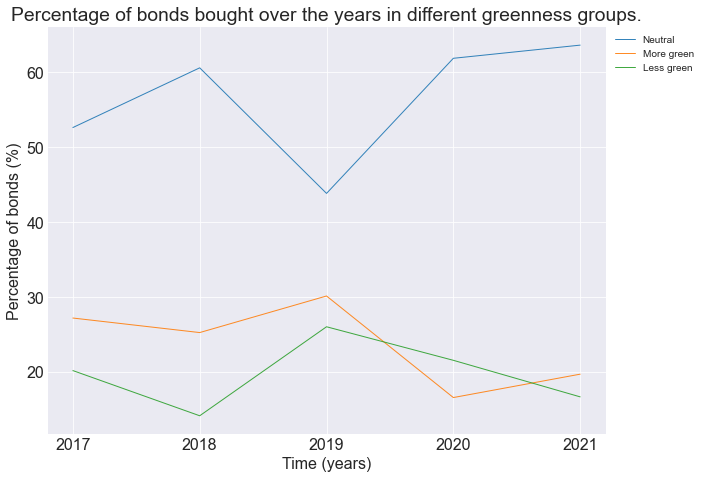

In [19]:
# Drawing a sphagetti plot by grouping sectors according to greenness
green_dict = {-1: "Less green", 0: "Neutral", 1: "More green"}
sector_mappings_modified = sector_mappings.copy()
sector_mappings_modified["hasPrimaryBusinessSector"] = sector_mappings_modified.Greenness.apply(lambda x: green_dict[x])
levels_of_greenness = pieCharts.get_all_sectors("hasPrimaryBusinessSector", sector_mappings_modified)
levels_of_greenness = sectors.map_green_dict_to_data_frame(levels_of_greenness)
sectors.draw_spaghetti_plot_sectors(levels_of_greenness, sector_mappings_modified, years_issuer_bought, title = "greenness groups")

# Company Analysis based on ESG scores

Function for cleaning the ESG data

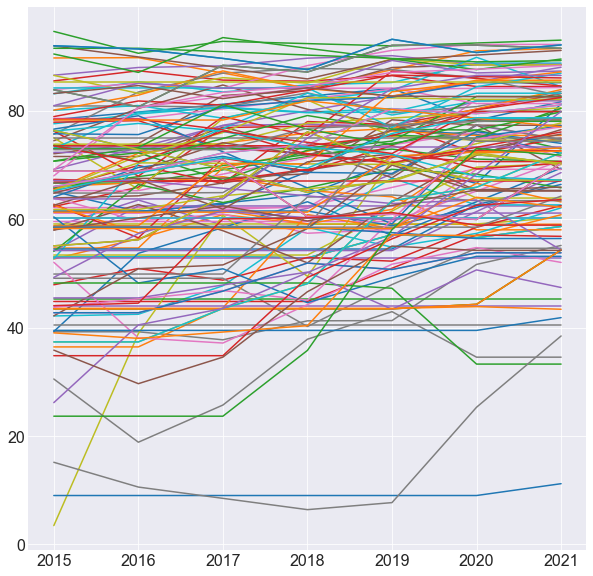

In [20]:
from functions import ESG
esg_company_data_eligible = ESG.cleaning_esg_data(eligible_complete)
esg_company_data_holdings = ESG.cleaning_esg_data(eikon_data_complete)
ESG.plot_ESG(esg_company_data_holdings)

## Descriptive Statistics

In [21]:
esg_company_data_holdings.describe()

,ESG Score 2015,ESG Score 2016,ESG Score 2017,ESG Score 2018,ESG Score 2019,ESG Score 2020,ESG Score 2021
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,62.156790,63.167049,64.976403,66.013230,68.266407,70.024616,71.151779
std,16.832183,16.563830,16.408036,15.688833,15.173085,14.653935,14.052443
min,3.485178,9.035207,8.511902,6.428276,7.725643,9.035207,11.218529
25%,52.976506,53.189321,54.312270,57.651837,58.623800,60.340022,62.485910
50%,63.953770,65.422763,66.917698,67.784729,70.247082,72.286777,72.441233
75%,73.817561,73.800401,76.984623,77.969904,79.110492,80.353174,82.051805
max,94.681897,91.568308,93.545750,92.430724,93.230124,92.542586,93.072831


In [22]:
esg_company_data_eligible.describe()

,ESG Score 2015,ESG Score 2016,ESG Score 2017,ESG Score 2018,ESG Score 2019,ESG Score 2020,ESG Score 2021
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,62.069953,63.995237,66.128372,67.472692,69.621426,70.497905,71.550933
std,19.055657,19.225019,17.977814,17.202404,16.394652,16.308647,15.747909
min,7.245926,14.533691,17.422135,18.792800,20.163466,25.318226,19.520247
25%,52.978833,55.010988,57.931346,59.222782,60.930691,64.037336,65.359909
50%,65.615280,67.266580,68.065178,69.602814,73.567484,73.959197,74.231511
75%,75.062302,78.451767,80.186580,81.979221,82.517499,82.742138,82.860713
max,91.992754,91.741976,91.769690,94.327360,93.230124,92.869364,92.869364


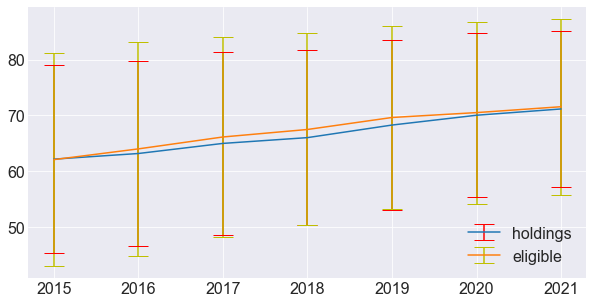

In [23]:
ESG.plot_ESG_error_bars(esg_company_data_eligible, esg_company_data_holdings)

In this figure, we can clearly see that the average ESG-score of the companies increases.

<AxesSubplot:>

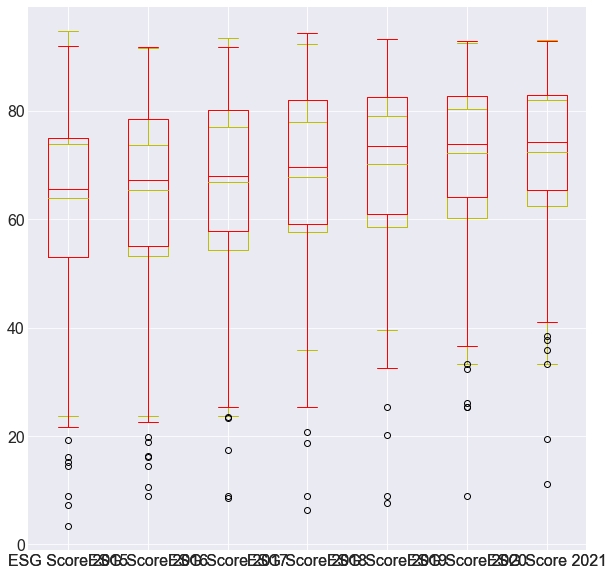

In [24]:
esg_company_data_holdings.iloc[:,1:].boxplot(figsize=(10,10),color='y')
esg_company_data_eligible.iloc[:,1:].boxplot(figsize=(10,10),color='r')

## ESG evolution of each company

fit the evolution of each company

Make a boxplot of the coefficients of these fits. This should give an indication about the general evolution (increase vs decrease).

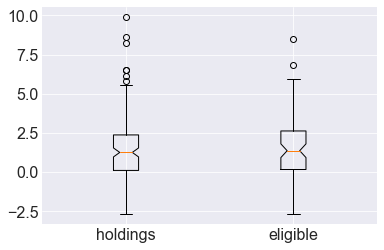

In [25]:
ESG.coefficients_box_plot(esg_company_data_eligible, esg_company_data_holdings)

This figure shows us that only roughly 25% of companies have a negative slope, while the other 75% have an increasin ESG score.

Let us now try to find a relation between the initial ESG score and the most recent one. This can be done by plotting and calculating the covariance matrix.

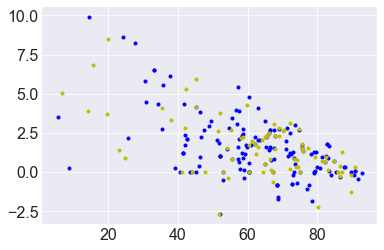

In [26]:
ESG.covariance_matrix_plot(esg_company_data_eligible, esg_company_data_holdings)

In [27]:
ESG.get_correlation_coefficients(esg_company_data_eligible, esg_company_data_holdings)

holdings:
 [[ 1.         -0.54811866]
 [-0.54811866  1.        ]] 
 eligible:
 [[ 1.         -0.58874652]
 [-0.58874652  1.        ]]


There seems to be some negative correlation ==> lower initial value, faster increase in ESG score.

## ESG Evolution of holdings through the years

In [28]:
esg_scores_per_year = ESG.get_ESG_scores_per_year(years_issuer_bought, esg_company_data_holdings) # TODO: remove line if not used in notebook

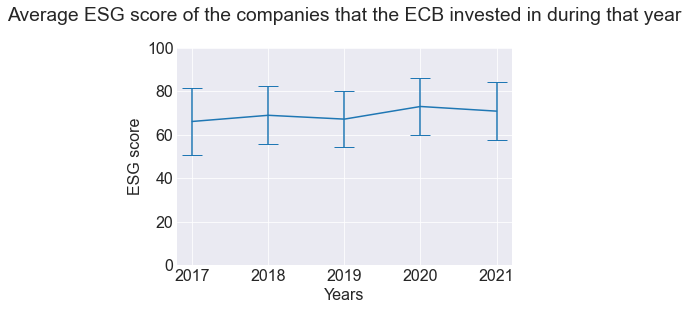

In [29]:
ESG.average_company_esg_score_plot(years_issuer_bought, esg_company_data_holdings)